# Data augmentation on the mnist roman dataset for Data-Centric competition

#### Refer to https://worksheets.codalab.org/worksheets/0x7a8721f11e61436e93ac8f76da83f0e6

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import json
import sys

import PIL
import PIL.Image
import pathlib
import matplotlib.pyplot as plt
import os

# tools for image storing
import shutil
import uuid

# to measure time intervals
import time

In [2]:
print(tf.__version__)

2.5.0


In [3]:
def plot_dataset_samples(dataset, figsize=10):
    plt.figure(figsize=(figsize, figsize))
    for images, labels in dataset.take(1):
        for i in range(images.shape[0]):
            ax = plt.subplot(2, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[list(labels[i]).index(1)])
            plt.axis("off")

In [4]:
def randomflip_dataset(dataset, data_flip_type='horizontal', exceptions=[]):
    data_augmentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip(data_flip_type),])
    numbers_of_batches = numbers_ds.cardinality().numpy()   
    for images, labels in dataset.take(numbers_of_batches):
        for i in range(images.shape[0]):
            if class_names[list(labels[i]).index(1)] not in exceptions:
                x = images[i]
                y = labels[i]
                #dataset.map((data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    
    
    return dataset

In [5]:
def do_augmentation_randomflip(dataset, data_flip_type='horizontal'):
    data_augmentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip(data_flip_type),])
    return dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

In [6]:
def do_augmentation_random_rotation(dataset, data_rotation_factor=0.2, exceptions=[]):
    data_augmentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomRotation(data_rotation_factor),])
    return dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

In [7]:
def do_augmentation_random_height(dataset, data_height_factor=0.2):
    data_augmentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomHeight(data_height_factor),])
    return dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
def do_augmentation_random_traslation(dataset, data_traslation_factor=0.2):
    data_augmentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomHeight(data_traslation_factor),])
    return dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
def dataset_save(dataset, directory, exceptions=[]):
    images_stored = []
    for images, labels in dataset:
        for i in range(images.shape[0]):
            cl = class_names[list(labels[i]).index(1)]
            if cl not in exceptions:
                filepath = os.path.join(directory , cl) + '/' + str(uuid.uuid4()) + '.png'
                tf.keras.preprocessing.image.save_img(filepath , images[i].numpy().astype("uint8"))
                images_stored.append(images[i])
    #return images_stored

In [10]:
data_dir = 'label_book'
augmentation_dir = 'augmentation/'

In [11]:
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.png')))
print(f'The folder {data_dir} contains {image_count} pictures of roman numbers')

The folder label_book contains 865 pictures of roman numbers


In [12]:
roman_numbers = "label_book"
class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"]
batch_size = 8
tf.random.set_seed(123)

In [15]:
if os.path.exists(augmentation_dir):
    shutil.rmtree(augmentation_dir)

if not os.path.exists(augmentation_dir):
    os.makedirs(augmentation_dir)

for cl in class_names:
    if not os.path.exists(os.path.join(augmentation_dir, cl)):
        os.makedirs(os.path.join(augmentation_dir, cl))

Let's visualize one roman number as example.

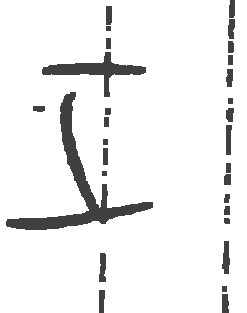

In [16]:
roman_i = list(data_dir.glob('i/*'))
PIL.Image.open(str(roman_i[0]))

Let's ingest the roman numbers by the API 'image_dataset_from_directory'. The labels will be inferred by the 'class_names' parameter.

In [17]:
numbers_ds = tf.keras.preprocessing.image_dataset_from_directory(
    roman_numbers,
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    shuffle=True,
    seed=123,
    batch_size=batch_size,
    image_size=(247, 313),
)

Found 865 files belonging to 10 classes.


In [18]:
print(f"The class names are {numbers_ds.class_names}")

The class names are ['i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x']


In [19]:
for image_batch, labels_batch in numbers_ds:
    print("Batch shape", image_batch.shape)
    print("Labels shape", labels_batch.shape)
    break

numbers_of_batches = numbers_ds.cardinality().numpy()
print("Number of batches:", numbers_of_batches)


Batch shape (8, 247, 313, 3)
Labels shape (8, 10)
Number of batches: 109


## Visualize the data

Here are the first 8 images from the dataset.

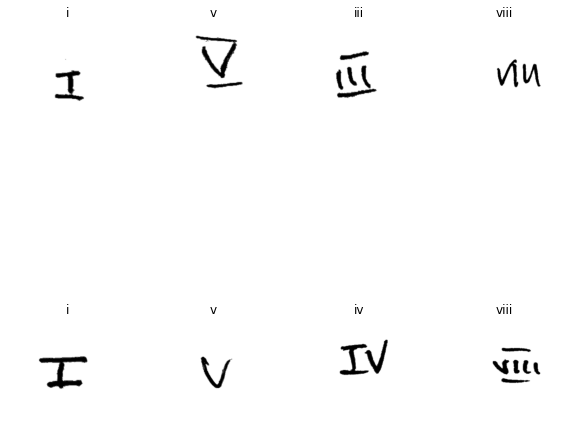

In [20]:
plot_dataset_samples(numbers_ds)

## Data augmentation

Now all the images have been loaded. We are ready to make some kind of data augmentation.\
Please refer to the following tutorial https://www.tensorflow.org/tutorials/images/data_augmentation.

### Horizontal flip

I    -->  I\
II   -->  II\
III  --> III\
IV   --> VI\
V    --> V\
VI   --> IV\
VII  --> IIV (not valid)\
VIII --> IIIV (not valid)\
IX   --> XI (not valid)\
X    --> X

So there are some exceptions that have to be taken into account when we will store the augmented data:

In [ ]:
horizontal_exceptions = ['vii', 'viii', 'ix']

In [ ]:
numbers_horizontal_ds = do_augmentation_randomflip(numbers_ds, data_flip_type="horizontal")

In [ ]:
print(type(numbers_horizontal_ds))

In [ ]:
plot_dataset_samples(numbers_horizontal_ds)

In [ ]:
dataset_save(numbers_horizontal_ds, augmentation_dir, horizontal_exceptions)

In [ ]:
print(type(numbers_horizontal_ds))

In [ ]:
'''
start = time.time()
randomflip_dataset(numbers_ds)
end = time.time()
print(f"elapsed {end - start}")
'''

### Vertical flip

I    -->  I\
II   -->  II\
III  --> III\
IV   --> not valid\
V    --> not valid\
VI   --> not valid\
VII  --> not valid\
VIII --> not valid\
IX   --> IX\
X    --> X

So there are some exceptions that have to be taken into account when we will store the augmented data:

In [ ]:
vertical_exceptions = ['iv', 'v', 'vi', 'vii', 'viii']

In [ ]:
numbers_vertical_ds = do_augmentation_randomflip(numbers_ds, data_flip_type="vertical")

In [ ]:
plot_dataset_samples(numbers_vertical_ds)

Not let's save only the images that correspond to a real roman numbers.

In [ ]:
dataset_save(numbers_vertical_ds, augmentation_dir, vertical_exceptions)

In [ ]:
exceptions = [[], horizontal_exceptions, vertical_exceptions]

### Data random rotation

In [21]:
rotations = [0.01, 0.05, 0.1]
datasets = [numbers_ds]
#datasets = [numbers_ds, numbers_horizontal_ds, numbers_vertical_ds]

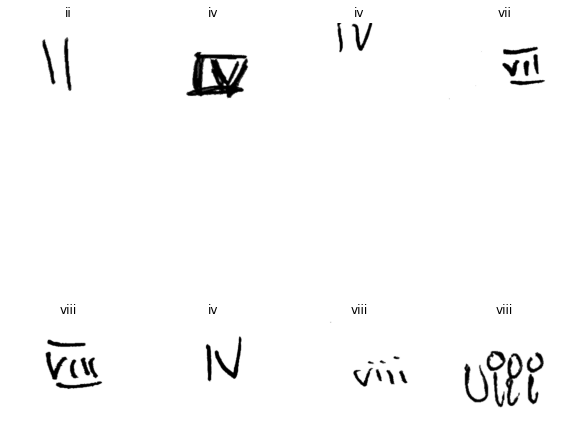

In [22]:
for rot in rotations:
    for idx, ds in enumerate(datasets):
        augmented_ds = do_augmentation_random_rotation(ds, data_rotation_factor=rot)
        dataset_save(augmented_ds, augmentation_dir)
plot_dataset_samples(ds)

### Data random height

In [23]:
heights = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
#datasets = [numbers_ds, numbers_horizontal_ds, numbers_vertical_ds]
datasets = [numbers_ds]

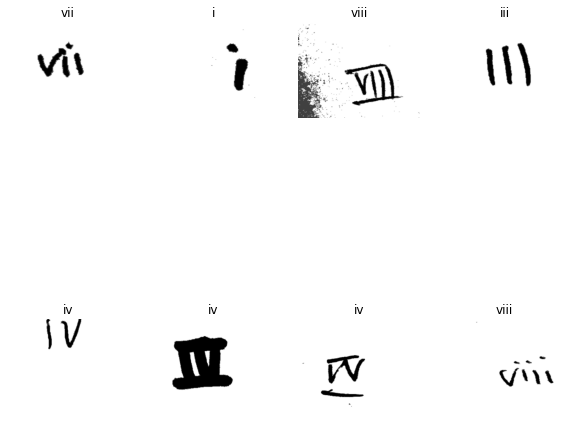

In [24]:
for h in heights:
    for idx, ds in enumerate(datasets):
        augmented_ds = do_augmentation_random_height(ds, data_height_factor=h)
        dataset_save(augmented_ds, augmentation_dir)
plot_dataset_samples(ds)

### Data random traslation

In [25]:
traslation = [0.1, 0.2, 0.3, 0.4, 0.5]
#datasets = [numbers_ds, numbers_horizontal_ds, numbers_vertical_ds]
datasets = [numbers_ds]

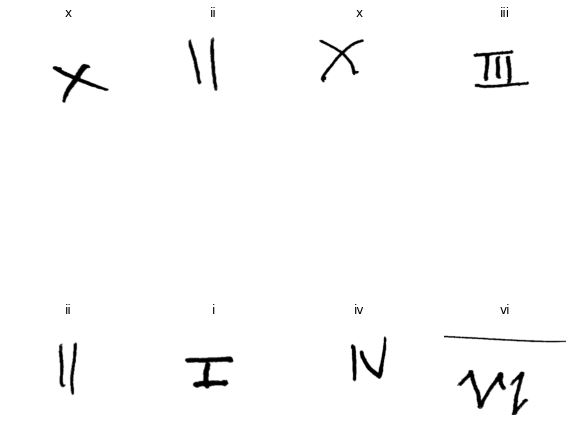

In [26]:
for h in traslation:
    for idx, ds in enumerate(datasets):
        augmented_ds = do_augmentation_random_traslation(ds, data_traslation_factor=h)
        dataset_save(augmented_ds, augmentation_dir)
plot_dataset_samples(ds)